### ELI5
Big investors try to keep their portfolios balanced, so if stocks do much better than bonds early in the month, they often sell some stocks and buy bonds near the end. That routine buying and selling can gently push prices back the other way late in the month, even if nothing important has changed. This rebalancing pressure can even spill into the first few days of the next month as positions continue to adjust.

# End-of-Month Rebalancing: VTI vs. TLT
End-of-month rebalancing is a recurring flow-driven pattern where institutional investors adjust portfolio weights near month-end to keep allocations aligned with mandates (e.g., 60/40 targets), risk limits, and reporting constraints. When one leg (equities or bonds) strongly outperforms earlier in the month, portfolios drift away from target weights. As month-end approaches, managers rebalance - selling the relative winner and buying the relative loser - creating a tendency toward late-month mean reversion in relative performance. This rebalancing activity can persist into the early days of the following month as institutional flows continue to normalize portfolio weights.

## Elevator pitch
### What would cause the inefficiency?
The inefficiency is caused by large, price-insensitive rebalancing flows near month-end and into the start of the next month. If VTI outperforms TLT early in the month, balanced portfolios become equity-heavy and may mechanically sell equities and buy bonds to restore target weights—first late in the month, then continuing into the first few trading days of the next month. If TLT outperforms VTI early, the opposite rebalancing occurs. Because these trades are driven by portfolio constraints and institutional process (rather than new information about fundamentals), they can create a systematic relationship between early-month relative performance and both late-month and early-next-month relative performance.

### Why it wouldn't be fully gobbled up by others who are quicker or better informed?
Even if the effect is known, it's hard to fully arbitrage because the edge is typically small, timing-sensitive, and varies across market regimes. The flows can be lumpy, crowding can reduce returns, and the strategy is exposed to event risk (macro surprises, CPI/FOMC, shocks) that can swamp a mild seasonal tendency. Additionally, the rebalancing pressure is driven by the largest allocators (pensions, balanced funds), and opposing it requires balance-sheet capacity at precisely the time when liquidity and risk limits can tighten into month-end and the turn of the month.

### How might a retail investor harness it, on average?
A retail investor can harness it with a simple, rules-based relative-positioning approach: condition on early-month relative performance (VTI vs TLT) and take a modest position aligned with the expected rebalancing direction during both the late-month window and the continuation window (first 5 trading days of the next month). The practical version is conditional, not unconditional: the reversal tendency should be tested primarily when early-month relative performance is meaningfully positive or negative (i.e., strong drift away from target weights), and often shows weaker behavior when early-month moves are small.

## Analysis

1. Download historical price data for VTI (equity ETF) and TLT (bond ETF) starting from 2000-01-01.
2. Calculate daily returns for both equities and bonds and combine into a single dataframe.
3. Add calendar features: year, month, year-month period, and trading day of month (DOTM) for each observation.
4. Define analysis windows: Early window (days 1-15), Late window (days 16-end of month), and Continuation window (first 5 days of next month).
5. Calculate cumulative returns for each window by compounding daily returns within the period.
6. Compute relative performance (equities - bonds) for early, late, and continuation windows.
7. Perform regression analysis to test the relationship between early-month relative performance and both late-month and continuation performance.
8. Split analysis by time periods (2000-2010, 2011-2018, 2019-2025) to examine regime-dependent behavior across all three windows.

## Backtest
The backtest implements a systematic rebalancing-reversal strategy based on early-month relative performance between equities and bonds, capturing both late-month and early-next-month continuation effects:

### Strategy Rules:
1. If bonds outperform early (Rel_early < 0): Go long equities during the late window (expecting rebalancing flows to buy equities)
2. If equities outperform early (Rel_early > 0): Go long bonds during the late window AND the continuation window (expecting rebalancing flows to buy bonds through month-end and into the next month)

### Backtest Steps:
1. Calculate late-window returns for each month based on the early-month signal
2. Calculate continuation-window returns (first 5 days of next month) when equities outperformed early
3. Combine late + continuation returns to produce the total monthly strategy return
4. Compute cumulative returns by compounding monthly strategy returns
5. Calculate performance metrics: annualized return, volatility, Sharpe ratio, and maximum drawdown
6. Visualize equity curve and drawdown profile over the full sample period
7. Analyze rolling 1-year metrics (return, volatility, Sharpe) to assess time-varying performance and regime sensitivity

## Analysis

In [ ]:
# Imports & parameters
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Parameters
START_DATE = '2000-01-01'

EARLY_WINDOW = (1, 15)  # Days 1-15
LATE_WINDOW = (16, 31)  # Days 16-end of month
CONTINUATION_WINDOW_DAYS = 5  # Days for continuation calculation

EQUITY = 'VTI'  # Equity ETF
BOND = 'TLT'    # Bond ETF

# European investor should use CSPX and DTLA (on LSE) in order to limit transaction costs

STARTING_BALANCE = 2500
TRANSACTION_COSTS = 0.0005  # 0.05% per trade

In [151]:
# Download equities and bonds data
equities = yf.download(EQUITY, start=START_DATE, auto_adjust=True, progress=False)
bonds = yf.download(BOND, start=START_DATE, auto_adjust=True, progress=False)

# Calculate daily returns
equities_returns = equities['Close'].squeeze().pct_change()
bonds_returns = bonds['Close'].squeeze().pct_change()

# Combine into a single dataframe
returns_df = pd.DataFrame({
    'equities': equities_returns,
    'bonds': bonds_returns
}).dropna()

# Add trading day of the month (DOTM)
# Group by year-month and assign sequential trading day numbers
returns_df['Year'] = returns_df.index.year
returns_df['Month'] = returns_df.index.month
returns_df['YearMonth'] = returns_df.index.to_period('M')

# Calculate trading day of month within each year-month group
returns_df['DOTM'] = returns_df.groupby('YearMonth').cumcount() + 1

In [152]:
# Function to calculate cumulative return for a window
def calc_window_return(group, ticker, window_start, window_end):
    """Calculate cumulative return for a ticker within a DOTM window"""
    mask = (group['DOTM'] >= window_start) & (group['DOTM'] <= window_end)
    returns = group.loc[mask, ticker]
    if len(returns) == 0:
        return None
    # Cumulative return: (1+r1)*(1+r2)*...*(1+rn) - 1
    return (1 + returns).prod() - 1

# Group by month and calculate early and late returns for equities and bonds
monthly_analysis = []

# Get sorted list of year-months
all_yearmonths = sorted(returns_df['YearMonth'].unique())

for idx, ym in enumerate(all_yearmonths):
    group = returns_df[returns_df['YearMonth'] == ym]
    
    # Early window returns
    equities_early = calc_window_return(group, 'equities', EARLY_WINDOW[0], EARLY_WINDOW[1])
    bonds_early = calc_window_return(group, 'bonds', EARLY_WINDOW[0], EARLY_WINDOW[1])
    
    # Late window returns
    equities_late = calc_window_return(group, 'equities', LATE_WINDOW[0], LATE_WINDOW[1])
    bonds_late = calc_window_return(group, 'bonds', LATE_WINDOW[0], LATE_WINDOW[1])
    
    # Continuation window returns (first CONTINUATION_WINDOW_DAYS of next month)
    equities_cont = None
    bonds_cont = None
    if idx < len(all_yearmonths) - 1:  # Check if there's a next month
        next_ym = all_yearmonths[idx + 1]
        next_group = returns_df[returns_df['YearMonth'] == next_ym]
        equities_cont = calc_window_return(next_group, 'equities', 1, CONTINUATION_WINDOW_DAYS)
        bonds_cont = calc_window_return(next_group, 'bonds', 1, CONTINUATION_WINDOW_DAYS)
    
    # Skip months with missing data
    if None in [equities_early, bonds_early, equities_late, bonds_late]:
        continue
    
    # Calculate relative returns
    rel_early = equities_early - bonds_early
    rel_late = equities_late - bonds_late
    rel_cont = None
    if equities_cont is not None and bonds_cont is not None:
        rel_cont = equities_cont - bonds_cont
    
    monthly_analysis.append({
        'YearMonth': ym,
        'Equities_early': equities_early,
        'Bonds_early': bonds_early,
        'Equities_late': equities_late,
        'Bonds_late': bonds_late,
        'Rel_early': rel_early,
        'Rel_late': rel_late,
        'Rel_continuation': rel_cont
    })

monthly_df = pd.DataFrame(monthly_analysis)
monthly_df.set_index('YearMonth', inplace=True)

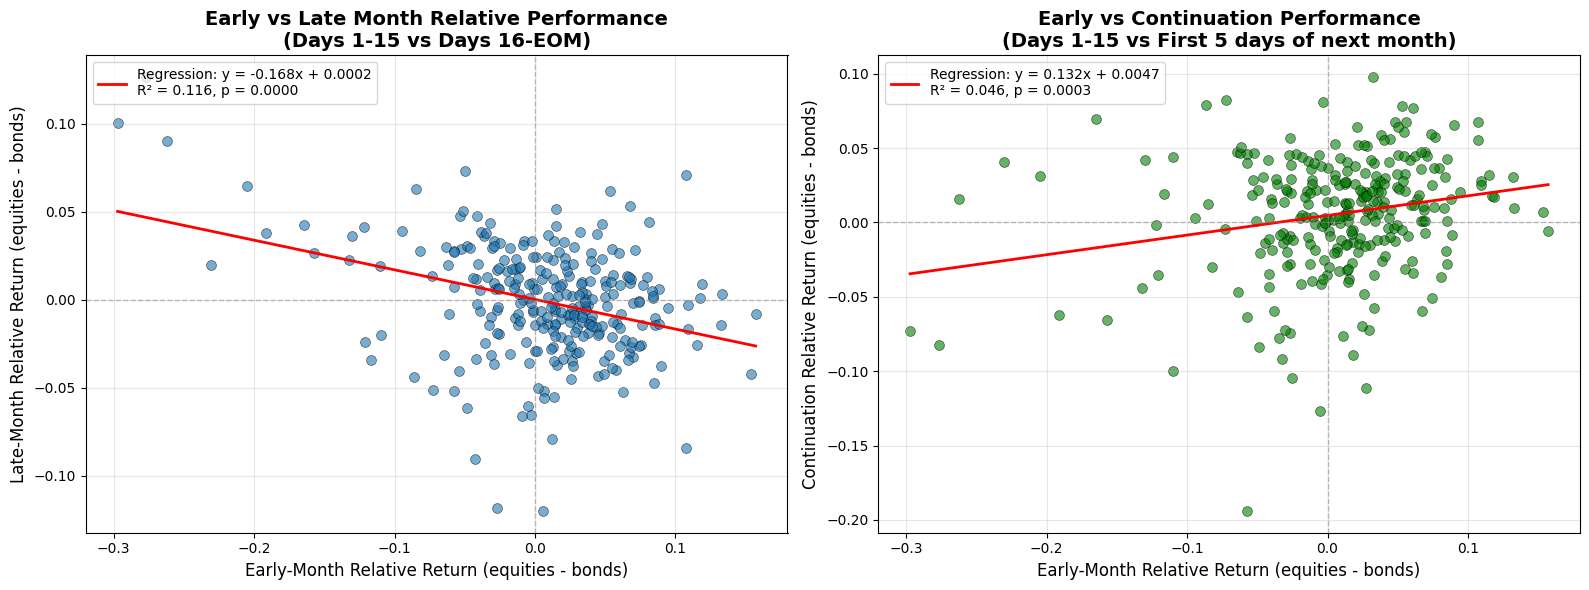

In [153]:
# Filter out months where Rel_continuation is not available
monthly_df_with_cont = monthly_df[monthly_df['Rel_continuation'].notna()].copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Rel_early vs Rel_late
ax1.scatter(monthly_df['Rel_early'], monthly_df['Rel_late'], 
           alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Calculate and plot regression line for Rel_early vs Rel_late
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(
    monthly_df['Rel_early'], monthly_df['Rel_late']
)

x_line1 = np.array([monthly_df['Rel_early'].min(), monthly_df['Rel_early'].max()])
y_line1 = slope1 * x_line1 + intercept1

ax1.plot(x_line1, y_line1, 'r-', linewidth=2, 
        label=f'Regression: y = {slope1:.3f}x + {intercept1:.4f}\nR² = {r_value1**2:.3f}, p = {p_value1:.4f}')

# Add horizontal and vertical lines at zero
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Labels and title
ax1.set_xlabel(f'Early-Month Relative Return (equities - bonds)', fontsize=12)
ax1.set_ylabel(f'Late-Month Relative Return (equities - bonds)', fontsize=12)
ax1.set_title(f'Early vs Late Month Relative Performance\n(Days {EARLY_WINDOW[0]}-{EARLY_WINDOW[1]} vs Days {LATE_WINDOW[0]}-EOM)', 
             fontsize=14, fontweight='bold')
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Rel_early vs Rel_continuation
ax2.scatter(monthly_df_with_cont['Rel_early'], monthly_df_with_cont['Rel_continuation'], 
           alpha=0.6, s=50, color='green', edgecolors='black', linewidth=0.5)

# Calculate and plot regression line for Rel_early vs Rel_continuation
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(
    monthly_df_with_cont['Rel_early'], monthly_df_with_cont['Rel_continuation']
)

x_line2 = np.array([monthly_df_with_cont['Rel_early'].min(), monthly_df_with_cont['Rel_early'].max()])
y_line2 = slope2 * x_line2 + intercept2

ax2.plot(x_line2, y_line2, 'r-', linewidth=2, 
        label=f'Regression: y = {slope2:.3f}x + {intercept2:.4f}\nR² = {r_value2**2:.3f}, p = {p_value2:.4f}')

# Add horizontal and vertical lines at zero
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Labels and title
ax2.set_xlabel(f'Early-Month Relative Return (equities - bonds)', fontsize=12)
ax2.set_ylabel(f'Continuation Relative Return (equities - bonds)', fontsize=12)
ax2.set_title(f'Early vs Continuation Performance\n(Days {EARLY_WINDOW[0]}-{EARLY_WINDOW[1]} vs First {CONTINUATION_WINDOW_DAYS} days of next month)', 
             fontsize=14, fontweight='bold')
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

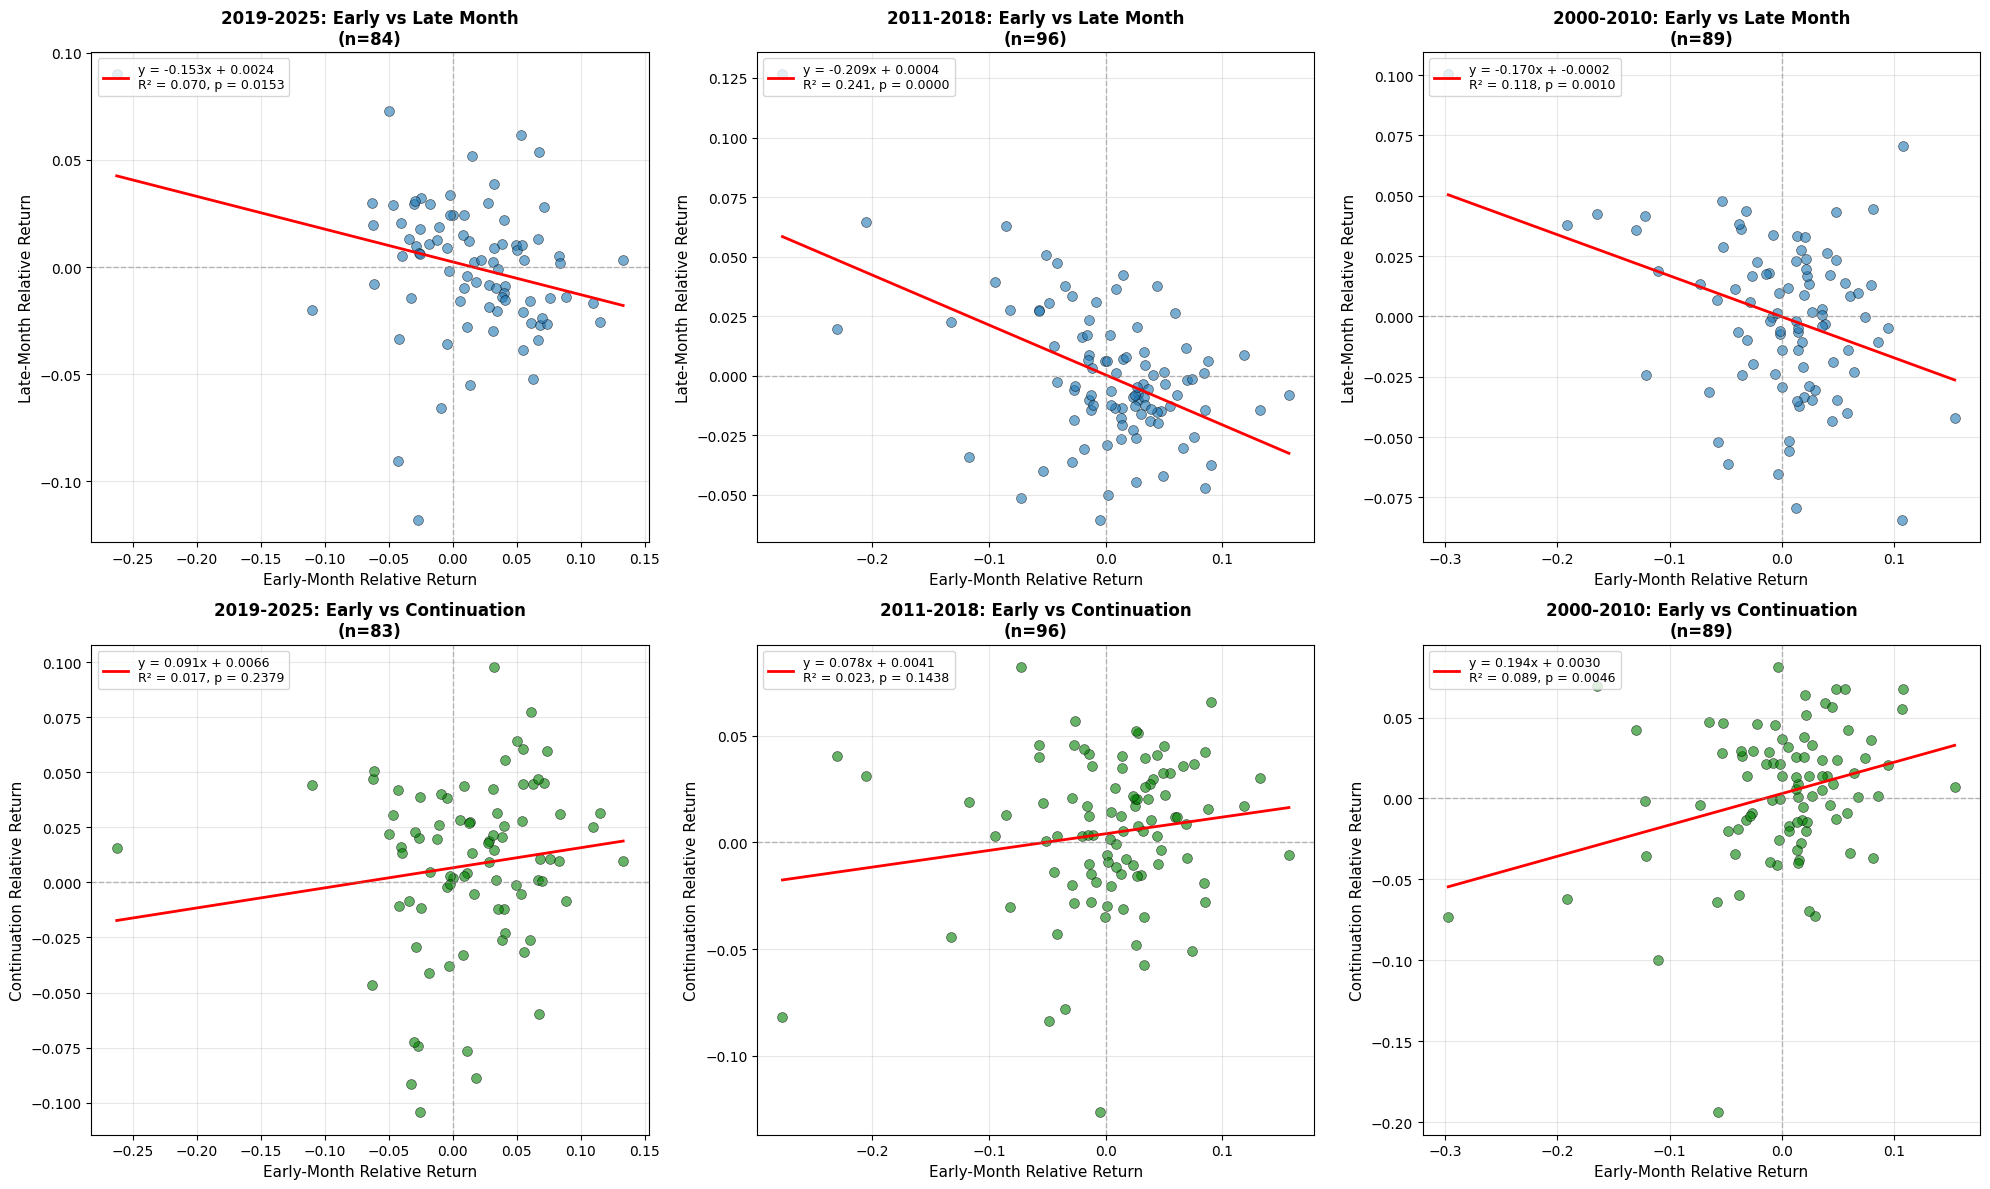

In [154]:
# Define year ranges
year_ranges = [
    (2019, 2025, '2019-2025'),
    (2011, 2018, '2011-2018'),
    (2000, 2009, '2000-2010')
]

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

for idx, (start_year, end_year, label) in enumerate(year_ranges):
    # Filter data by year range
    mask = (monthly_df.index.year >= start_year) & (monthly_df.index.year <= end_year)
    monthly_df_period = monthly_df[mask].copy()
    monthly_df_period_with_cont = monthly_df_period[monthly_df_period['Rel_continuation'].notna()].copy()
    
    # Plot 1: Rel_early vs Rel_late (top row)
    ax1 = axes[0, idx]
    ax1.scatter(monthly_df_period['Rel_early'], monthly_df_period['Rel_late'], 
               alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # Calculate and plot regression line for Rel_early vs Rel_late
    if len(monthly_df_period) > 1:
        slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(
            monthly_df_period['Rel_early'], monthly_df_period['Rel_late']
        )
        
        x_line1 = np.array([monthly_df_period['Rel_early'].min(), monthly_df_period['Rel_early'].max()])
        y_line1 = slope1 * x_line1 + intercept1
        
        ax1.plot(x_line1, y_line1, 'r-', linewidth=2, 
                label=f'y = {slope1:.3f}x + {intercept1:.4f}\nR² = {r_value1**2:.3f}, p = {p_value1:.4f}')
    
    ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax1.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax1.set_xlabel(f'Early-Month Relative Return', fontsize=11)
    ax1.set_ylabel(f'Late-Month Relative Return', fontsize=11)
    ax1.set_title(f'{label}: Early vs Late Month\n(n={len(monthly_df_period)})', 
                 fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9, loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Rel_early vs Rel_continuation (bottom row)
    ax2 = axes[1, idx]
    ax2.scatter(monthly_df_period_with_cont['Rel_early'], monthly_df_period_with_cont['Rel_continuation'], 
               alpha=0.6, s=50, color='green', edgecolors='black', linewidth=0.5)
    
    # Calculate and plot regression line for Rel_early vs Rel_continuation
    if len(monthly_df_period_with_cont) > 1:
        slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(
            monthly_df_period_with_cont['Rel_early'], monthly_df_period_with_cont['Rel_continuation']
        )
        
        x_line2 = np.array([monthly_df_period_with_cont['Rel_early'].min(), 
                           monthly_df_period_with_cont['Rel_early'].max()])
        y_line2 = slope2 * x_line2 + intercept2
        
        ax2.plot(x_line2, y_line2, 'r-', linewidth=2, 
                label=f'y = {slope2:.3f}x + {intercept2:.4f}\nR² = {r_value2**2:.3f}, p = {p_value2:.4f}')
    
    ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax2.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax2.set_xlabel(f'Early-Month Relative Return', fontsize=11)
    ax2.set_ylabel(f'Continuation Relative Return', fontsize=11)
    ax2.set_title(f'{label}: Early vs Continuation\n(n={len(monthly_df_period_with_cont)})', 
                 fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9, loc='upper left')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Backtest

In [155]:
# Backtest with updated strategy rules
# Rule 1: If bonds outperform early (Rel_early < 0), go long equities late
# Rule 2: If equities outperform early (Rel_early > 0), go long bonds late AND continuation

# Create a copy of monthly_df for the backtest
backtest_new = monthly_df.copy()

# Late window strategy
backtest_new['Strategy_late'] = np.where(
    backtest_new['Rel_early'] < 0,  # Bonds outperformed early
    backtest_new['Equities_late'],  # Go long equities late
    backtest_new['Bonds_late']      # Go long bonds late (when equities outperformed early)
)

# Continuation window strategy - only applies when equities outperformed early
backtest_new['Strategy_continuation'] = np.where(
    backtest_new['Rel_early'] > 0,
    backtest_new['Rel_continuation'].fillna(0),
    0
)

# Combined strategy: late + continuation (when applicable)
backtest_new['Strategy_return'] = backtest_new['Strategy_late'] + backtest_new['Strategy_continuation']

# Calculate transaction costs: 2x for each nonzero Strategy_late, 2x for each nonzero Strategy_continuation
backtest_new['Transaction_costs'] = (
    2 * TRANSACTION_COSTS * (backtest_new['Strategy_late'] != 0).astype(int) +
    2 * TRANSACTION_COSTS * (backtest_new['Strategy_continuation'] != 0).astype(int)
)

# Calculate cumulative returns (subtract transaction costs from each period's return)
backtest_new['Cumulative_strategy'] = (1 + backtest_new['Strategy_return'] - backtest_new['Transaction_costs']).cumprod()
backtest_new['Cumulative_balance'] = STARTING_BALANCE * backtest_new['Cumulative_strategy']
backtest_new['Cumulative_transaction_costs'] = STARTING_BALANCE * (1 - (1 + backtest_new['Transaction_costs']).cumprod())

# Calculate maximum drawdown
def calculate_max_drawdown(cumulative_returns):
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    return drawdown.min()

max_dd = calculate_max_drawdown(backtest_new['Cumulative_strategy'])

# Calculate performance metrics
n_years = len(backtest_new) / 12  # Monthly data
total_ret = backtest_new['Cumulative_strategy'].iloc[-1] - 1
ann_ret = (1 + total_ret) ** (1 / n_years) - 1
ann_vol = backtest_new['Strategy_return'].std() * np.sqrt(12)
sharpe = ann_ret / ann_vol if ann_vol != 0 else 0

# Print results
print("=" * 60)
print("BACKTEST RESULTS")
print("=" * 60)
print(f"Strategy: \n * if bonds outperform early, go long equities late\n * if equities outperform early, go long bonds late AND continuation")
print(f"Period: {backtest_new.index[0]} to {backtest_new.index[-1]}")
print(f"Number of years: {n_years:.2f}")
print("-" * 60)
print(f"Total Return: {total_ret * 100:.2f}%")
print(f"Cumulative Balance: ${backtest_new['Cumulative_balance'].iloc[-1]:.2f}")
print(f"Cumulative Transaction Costs Paid: ${backtest_new['Cumulative_transaction_costs'].iloc[-1]:.2f}")
print(f"Annualized Return: {ann_ret * 100:.2f}%")
print(f"Annualized Volatility: {ann_vol * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.3f}")
print(f"Maximum Drawdown: {max_dd * 100:.2f}%")
print("=" * 60)

BACKTEST RESULTS
Strategy: 
 * if bonds outperform early, go long equities late
 * if equities outperform early, go long bonds late AND continuation
Period: 2002-08 to 2025-12
Number of years: 23.42
------------------------------------------------------------
Total Return: 2752.42%
Cumulative Balance: $71310.59
Cumulative Transaction Costs Paid: $-1431.00
Annualized Return: 15.38%
Annualized Volatility: 12.02%
Sharpe Ratio: 1.280
Maximum Drawdown: -22.18%


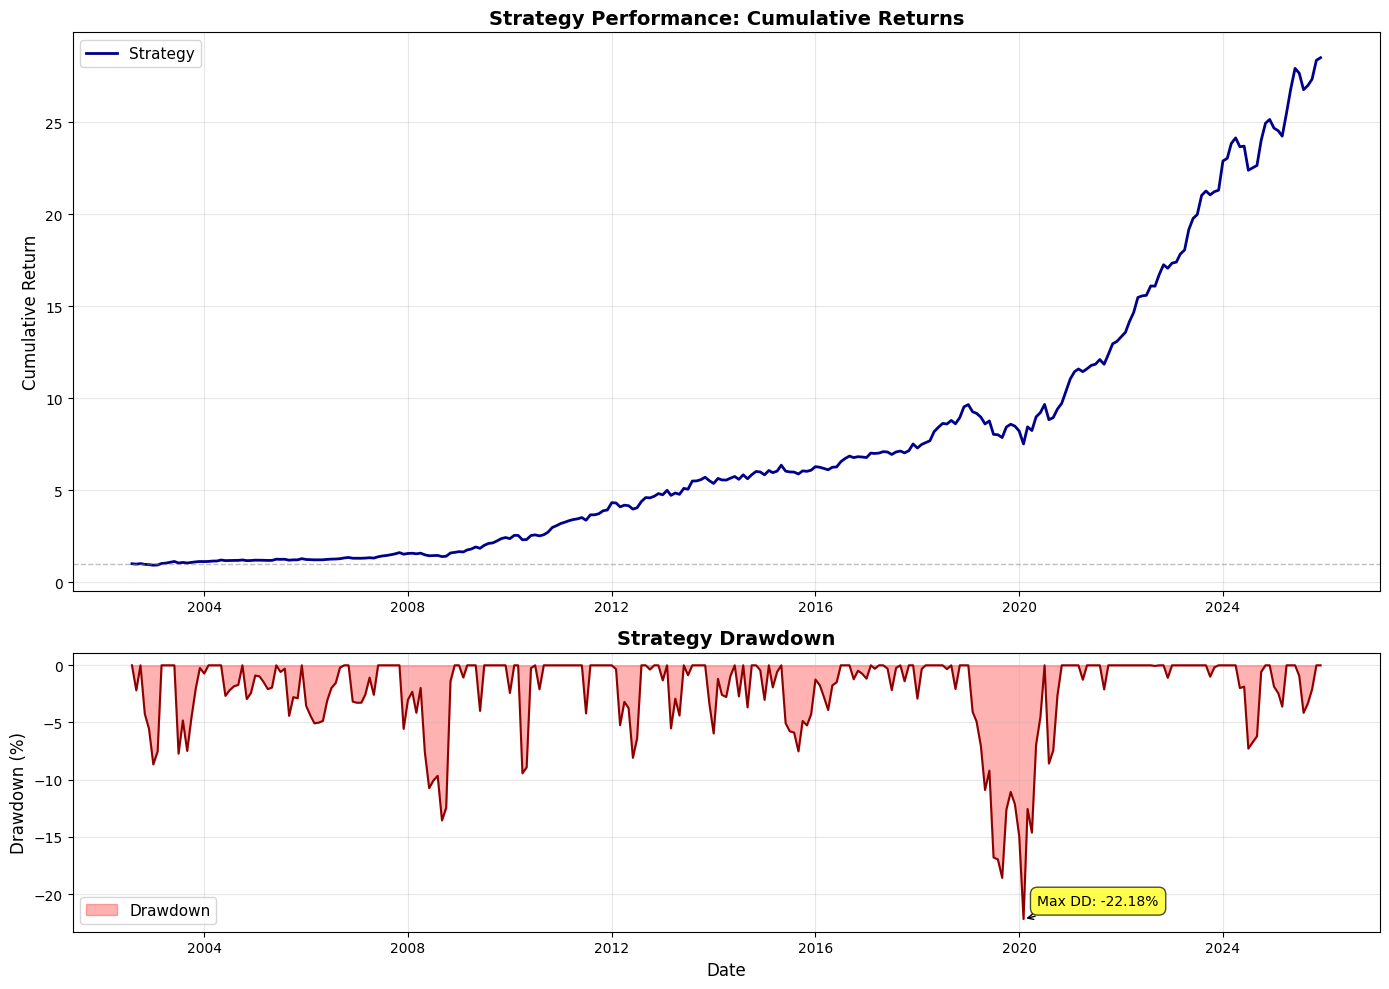

In [156]:
# Create strategy performance and drawdown plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# Plot 1: Cumulative Returns (Equity Curve)
ax1.plot(backtest_new.index.to_timestamp(), backtest_new['Cumulative_strategy'], 
         linewidth=2, label='Strategy', color='darkblue')
ax1.set_ylabel('Cumulative Return', fontsize=12)
ax1.set_title('Strategy Performance: Cumulative Returns', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Plot 2: Drawdown
running_max = backtest_new['Cumulative_strategy'].cummax()
drawdown = (backtest_new['Cumulative_strategy'] - running_max) / running_max

ax2.fill_between(drawdown.index.to_timestamp(), drawdown * 100, 0, 
                 color='red', alpha=0.3, label='Drawdown')
ax2.plot(drawdown.index.to_timestamp(), drawdown * 100, 
         linewidth=1.5, color='darkred')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_title('Strategy Drawdown', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='lower left')
ax2.grid(True, alpha=0.3)

# Add annotation for max drawdown
max_dd_date = drawdown.idxmin()
ax2.annotate(f'Max DD: {max_dd*100:.2f}%', 
             xy=(max_dd_date.to_timestamp(), drawdown.min()*100),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

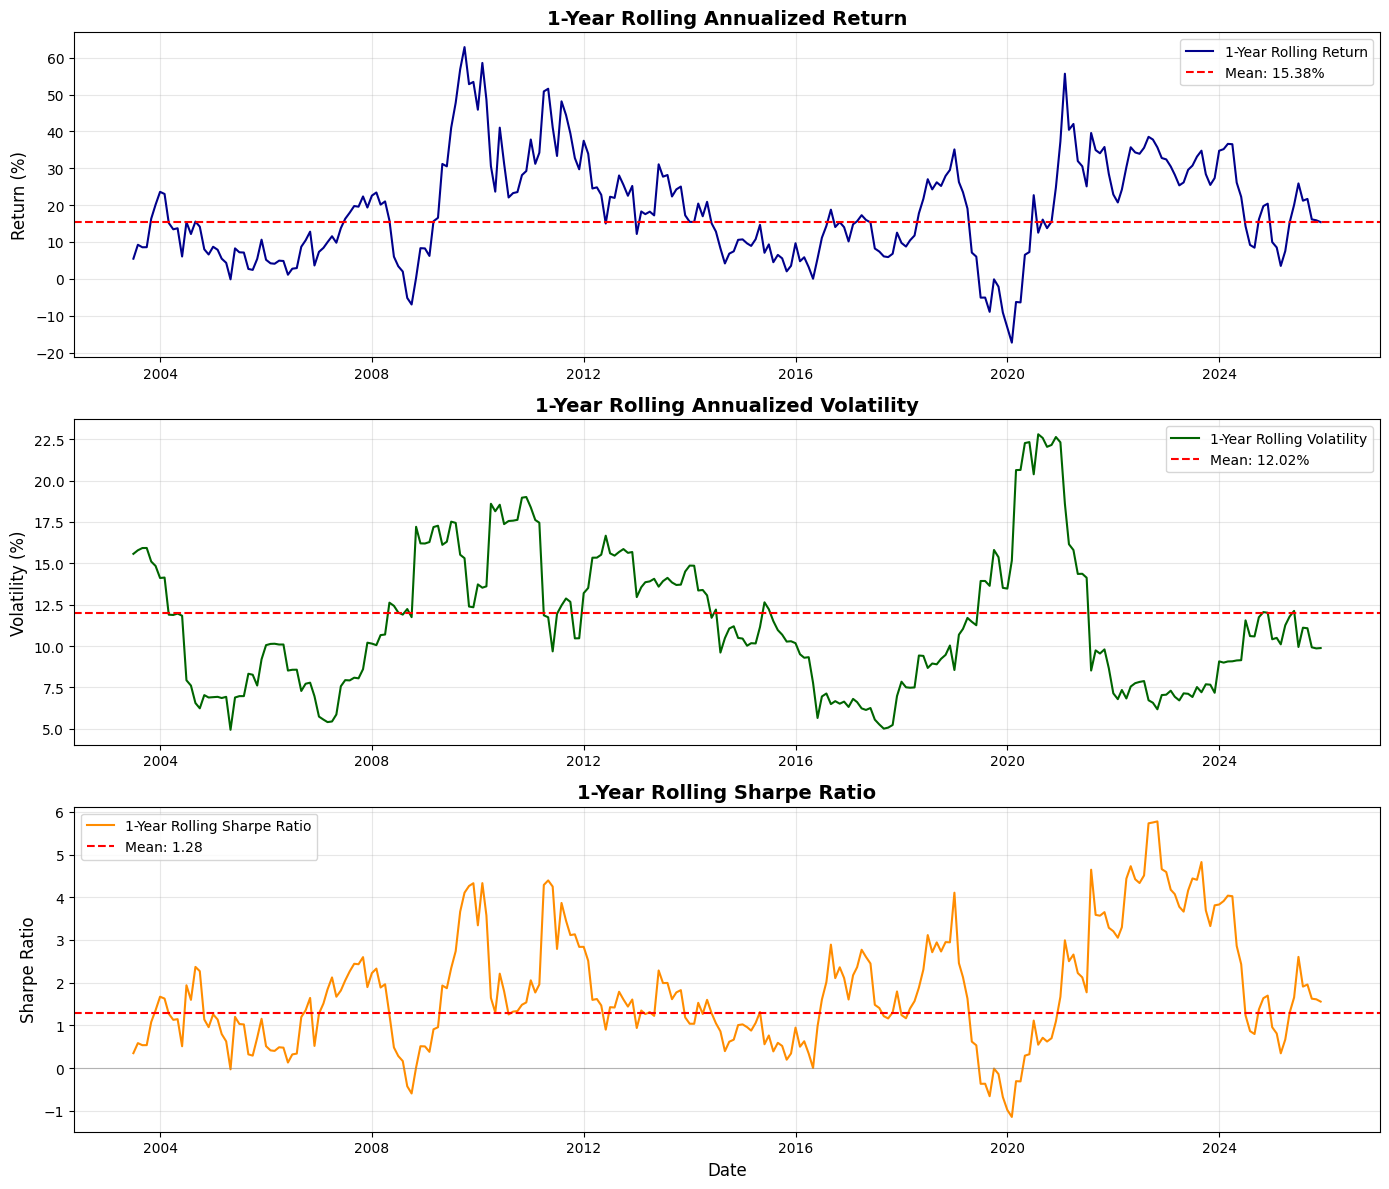

In [157]:
# Calculate 1-year rolling metrics for the strategy
rolling_window = 12  # 12 months = 1 year

# 1-year rolling return (annualized)
rolling_return = backtest_new['Strategy_return'].rolling(window=rolling_window).apply(
    lambda x: (1 + x).prod() - 1
)

# 1-year rolling volatility (annualized)
rolling_vol = backtest_new['Strategy_return'].rolling(window=rolling_window).std() * np.sqrt(12)

# 1-year rolling Sharpe ratio
rolling_sharpe = rolling_return / rolling_vol

# Create the plots
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Rolling Return
ax1 = axes[0]
ax1.plot(rolling_return.index.to_timestamp(), rolling_return * 100, 
         linewidth=1.5, color='darkblue', label='1-Year Rolling Return')
ax1.axhline(y=ann_ret * 100, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {ann_ret * 100:.2f}%')
ax1.set_ylabel('Return (%)', fontsize=12)
ax1.set_title('1-Year Rolling Annualized Return', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling Volatility
ax2 = axes[1]
ax2.plot(rolling_vol.index.to_timestamp(), rolling_vol * 100, 
         linewidth=1.5, color='darkgreen', label='1-Year Rolling Volatility')
ax2.axhline(y=ann_vol * 100, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {ann_vol * 100:.2f}%')
ax2.set_ylabel('Volatility (%)', fontsize=12)
ax2.set_title('1-Year Rolling Annualized Volatility', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Rolling Sharpe Ratio
ax3 = axes[2]
ax3.plot(rolling_sharpe.index.to_timestamp(), rolling_sharpe, 
         linewidth=1.5, color='darkorange', label='1-Year Rolling Sharpe Ratio')
ax3.axhline(y=sharpe, color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {sharpe:.2f}')
ax3.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('Sharpe Ratio', fontsize=12)
ax3.set_title('1-Year Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()